# Confusion Matrix

 ## Libraries

In [2]:
#general use and reading in the data
import os
import numpy as np
import pandas as pd

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

#transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#splitting data
from sklearn.model_selection import train_test_split

#models
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#GridSearchCV
from sklearn.model_selection import GridSearchCV

#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#confusion matrix
from sklearn.metrics import confusion_matrix

#classification_report
from sklearn.metrics import classification_report

#precision recall curve
from sklearn.metrics import precision_recall_curve

#roc curve
from sklearn.metrics import roc_curve

#auc score
from sklearn.metrics import roc_auc_score

## 1. Reading in the data
## 2. Features and target selection

In [3]:
pwd = os.getcwd()
data = os.path.join(pwd, "data.csv")
df = pd.read_csv(data)
#sanity check:
#df.head()

features = df[["Pclass", "Sex", "Fare"]]
target = df[["Survived"]]

In [4]:
target_dist = target.value_counts(normalize=True, ascending=True)
target_dist

Survived
1           0.383838
0           0.616162
dtype: float64

Text(0.5, 1.0, 'target distribution')

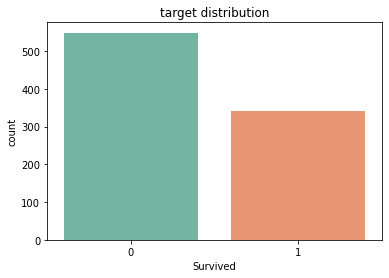

In [5]:
sns.countplot(x="Survived", data=df,  palette="Set2")
plt.title("target distribution")

## 3. Transformer

* be aware leaking of data by scaling across train, valid and test data, see pipeline

In [6]:
ct = ColumnTransformer([
    ("onhot", OneHotEncoder(sparse=False), ["Pclass", "Sex"]),
    ("scaling", StandardScaler(),["Fare"])
])

features_fit_trans = ct.fit_transform(features)
# #sanity check:
# features_fit_trans

## 4. Splitting data

- traininng set
- validation set
- testing set

In [7]:
X_trainval, X_test, y_trainval, y_test = train_test_split(features_fit_trans, np.ravel(target), random_state=0, stratify=target)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, np.ravel(y_trainval), random_state=0, stratify=y_trainval)

## sanity check (distribution of target):
# y_valid_dist = pd.DataFrame(y_valid)
# y_valid_dist.value_counts(normalize=True)

print(
    "Training set (X_train):    ", pd.DataFrame(X_train).shape
)
print(
    "Validation set (X_valid):  ",pd.DataFrame(X_valid).shape
)
print(
    "Test set (X_test):         ",pd.DataFrame(X_test).shape
)

Training set (X_train):     (501, 6)
Validation set (X_valid):   (167, 6)
Test set (X_test):          (223, 6)


## Dummy Classifier
- as baseline accuracy

In [8]:
dummy = DummyClassifier()
dummy.fit(X_train, np.ravel(y_train))
dummy.score(X_valid, y_valid)

0.6167664670658682

## 5. Grid Search - SVC

In [10]:
param_grid_svc = {
    "C":[0.001,0.01,0.1,1,10,100],
    "gamma":[0.001,0.01,0.1,1,10,100]
}

#scoring= "roc_auc"
#scoring= "accuracy"
#https://scikit-learn.org/stable/modules/model_evaluation.html
#beaware of one-sided target, e.g. cancer screening, is accuracy (defualt) being the most important scoring for gridsearch?
grid_search_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, return_train_score=True)

grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [56]:
print(
    "\nTest set score: {:5f}\n".format(grid_search_svc.score(X_test, y_test))
)
print(
    "Best cross-validation score: {:.2f}".format(grid_search_svc.best_score_)
)
print(
    "Best parameters: {}".format(grid_search_svc.best_params_)
)
print(
    "Best best_estimator_: {}".format(grid_search_svc.best_estimator_)
)


Test set score: 0.780269

Best cross-validation score: 0.82
Best parameters: {'C': 10, 'gamma': 1}
Best best_estimator_: SVC(C=10, gamma=1)


Text(0.5, 1.0, 'SVC - GridSearchCV Heatmap')

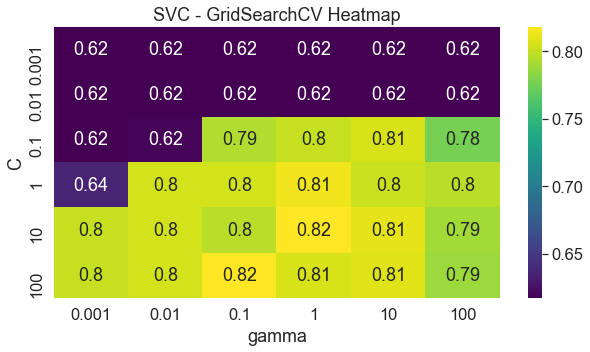

In [12]:
results_svc = pd.DataFrame(grid_search_svc.cv_results_)
# results_svc.head(1)
scores_svc = np.array(results_svc["mean_test_score"]).reshape(6,6)

#Viz figure size and font size settings
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

#sns heatmap
#best score should not be at the edge
sns.heatmap(
    scores_svc,
    annot=True,
    cmap="viridis",
    xticklabels=param_grid_svc["gamma"],
    yticklabels=param_grid_svc["C"]
)

#titles, x,y-labels
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("SVC - GridSearchCV Heatmap")

## 5. Grid Search - KNN

In [13]:
param_knn = {
    "n_neighbors":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    }

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=5, return_train_score=True)
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]},
             return_train_score=True)

In [53]:
print(
    "\nTest set score: {:.2f}\n".format(grid_search_knn.score(X_test, y_test))
)
print(
    "Best parameters: {}".format(grid_search_knn.best_params_)
)
print(
    "Best cross-validation score: {:.2f}".format(grid_search_knn.best_score_)
)
print(
    "Best best_estimator_: {}".format(grid_search_knn.best_estimator_)
)


Test set score: 0.78

Best parameters: {'n_neighbors': 8}
Best cross-validation score: 0.82
Best best_estimator_: KNeighborsClassifier(n_neighbors=8)


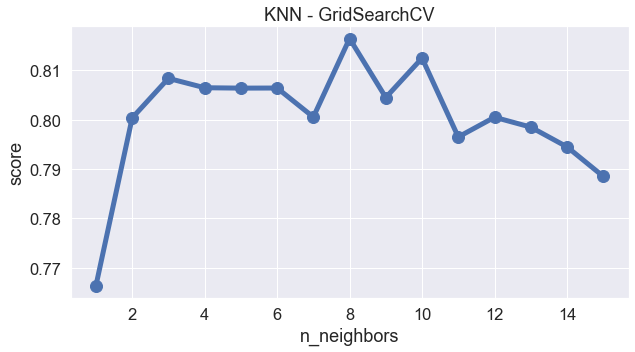

In [15]:
#showing all gridsearchcv results
results_knn = pd.DataFrame(grid_search_knn.cv_results_)
# #sanity check:
# display(results.head())

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

plt.plot(
    results_knn["param_n_neighbors"],
    results_knn["mean_test_score"],
    linewidth=5,
    marker="o",
    markersize=12)

plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.title("KNN - GridSearchCV")
plt.show()

#for more fancy settings, go to: 
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html

## 5. Grid Search - Logistic Regression

In [16]:
param_logreg = {"C":[0.001,0.01,0.1,1,10,100]}

grid_search_logreg = GridSearchCV(LogisticRegression(),param_logreg, cv=5, return_train_score=True)
grid_search_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [44]:
print(
    "\nTest set score: {:.2f}\n".format(grid_search_logreg.score(X_test, y_test))
)
print(
    "Best parameters: {}".format(grid_search_logreg.best_params_)
)
print(
    "Best cross-validation score: {:.2f}".format(grid_search_logreg.best_score_)
)
print(
    "Best best_estimator_: {}".format(grid_search_logreg.best_estimator_)
)


Test set score: 0.77

Best parameters: {'C': 1}
Best cross-validation score: 0.80
Best best_estimator_: LogisticRegression(C=1)


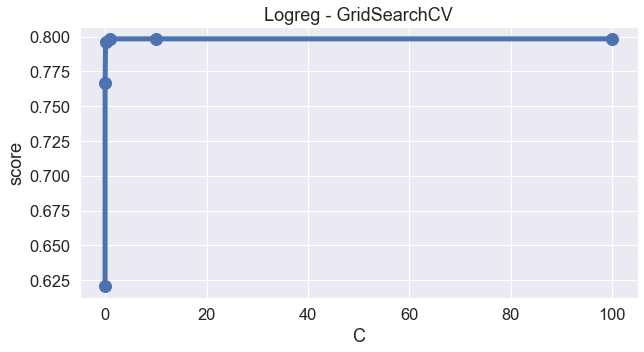

In [18]:
#showing all gridsearchcv results
results_logreg = pd.DataFrame(grid_search_logreg.cv_results_)
#sanity check:
#display(results_logreg.head())

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

plt.plot(
    results_logreg["param_C"],
    results_logreg["mean_test_score"],
    linewidth=5,
    marker="o",
    markersize=12)

plt.xlabel("C")
plt.ylabel("score")
plt.title("Logreg - GridSearchCV")
plt.show()


## 6. Nested CV

In [19]:
nested_score_svc = cross_val_score(
    GridSearchCV(SVC(),param_grid_svc, cv=5, n_jobs=-1),
    features_fit_trans, np.ravel(target), cv=5, n_jobs=-1
    )

nested_score_knn = cross_val_score(
    GridSearchCV(KNeighborsClassifier(),param_knn, cv=5, n_jobs=-1),
    features_fit_trans, np.ravel(target), cv=5, n_jobs=-1
    )

nested_score_logreg = cross_val_score(
    GridSearchCV(LogisticRegression(),param_logreg, cv=5, n_jobs=-1),
    features_fit_trans, np.ravel(target), cv=5, n_jobs=-1
    )

In [21]:
print(
    "SVC Nested CV score:      ", nested_score_svc.mean()
)

print(
    "KNN Nested CV score:      ", nested_score_knn.mean()
)

print(
    "Logreg Nested CV score:   ", nested_score_logreg.mean()
)

SVC Nested CV score:       0.7969116816270164
KNN Nested CV score:       0.7879166405122089
Logreg Nested CV score:    0.7788839369782187


## 7. Confusion Matrix

In [22]:
pred_dummy = dummy.predict(X_test)
confusion_dummy = confusion_matrix(y_test, pred_dummy)

svc = SVC(C=10, gamma=1)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
confusion_svc = confusion_matrix(y_test, pred_svc)

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
confusion_knn = confusion_matrix(y_test, pred_knn)

logreg = LogisticRegression(C=1)
logreg.fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
confusion_logreg = confusion_matrix(y_test, pred_logreg)

print(
    "dummy\n",
    confusion_dummy,
    "\n\nsvc\n",
    confusion_svc,
    "\n\nknn\n",
    confusion_knn,
    "\n\nlogreg\n",
    confusion_logreg
)

dummy
 [[137   0]
 [ 86   0]] 

svc
 [[125  12]
 [ 37  49]] 

knn
 [[131   6]
 [ 42  44]] 

logreg
 [[114  23]
 [ 29  57]]


In [23]:
target_names=['dead','survived']

print(
    "SVC\n",
    classification_report(y_test, pred_svc, target_names=target_names)
)
print(
    "KNN\n",
    classification_report(y_test, pred_knn, target_names=target_names)
)
print(
    "Logreg\n",
    classification_report(y_test, pred_logreg, target_names=target_names)
)

SVC
               precision    recall  f1-score   support

        dead       0.77      0.91      0.84       137
    survived       0.80      0.57      0.67        86

    accuracy                           0.78       223
   macro avg       0.79      0.74      0.75       223
weighted avg       0.78      0.78      0.77       223

KNN
               precision    recall  f1-score   support

        dead       0.76      0.96      0.85       137
    survived       0.88      0.51      0.65        86

    accuracy                           0.78       223
   macro avg       0.82      0.73      0.75       223
weighted avg       0.80      0.78      0.77       223

Logreg
               precision    recall  f1-score   support

        dead       0.80      0.83      0.81       137
    survived       0.71      0.66      0.69        86

    accuracy                           0.77       223
   macro avg       0.75      0.75      0.75       223
weighted avg       0.76      0.77      0.77       223



## 8. Precision-recall Curves
- to decide operating point
- .predict_proba() or .decision_function()

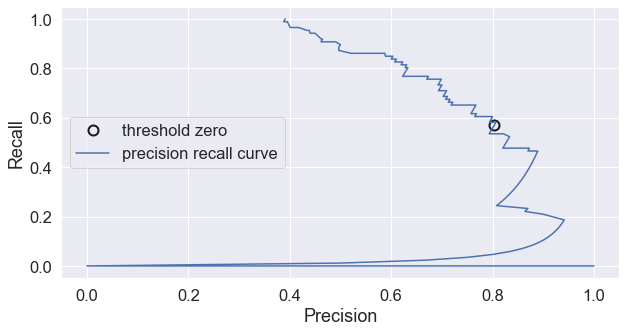

In [24]:
#SVC

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_test, svc.decision_function(X_test))

close_zero_svc = np.argmin(np.abs(thresholds_svc))

plt.plot(precision_svc[close_zero_svc], recall_svc[close_zero_svc], "o", markersize=10, label="threshold zero",fillstyle="none", c="k", mew=2)

plt.plot(precision_svc, recall_svc, label="precision recall curve")

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

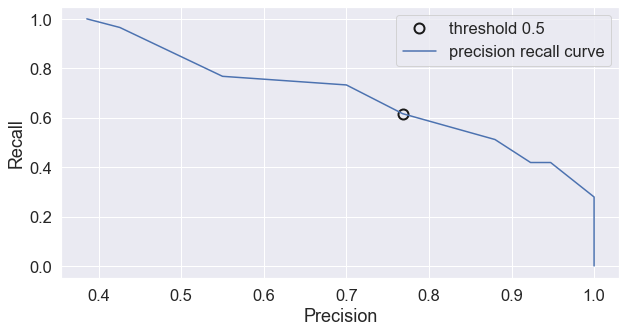

In [25]:
#KNN

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, knn.predict_proba(X_test)[:,1])

close_zero_knn = np.argmin(np.abs(thresholds_knn - 0.5))

plt.plot(precision_knn[close_zero_knn], recall_knn[close_zero_knn], "o", markersize=10, label="threshold 0.5",fillstyle="none", c="k", mew=2)

plt.plot(precision_knn, recall_knn, label="precision recall curve")

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

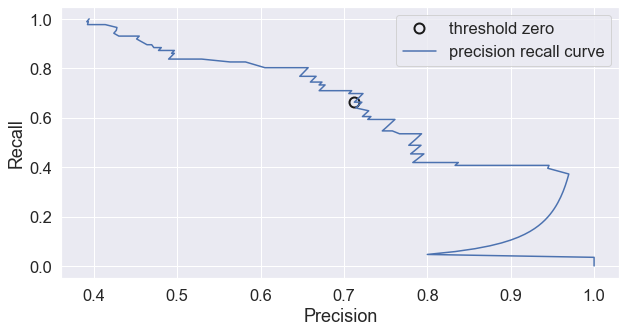

In [26]:
#logreg

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test, logreg.decision_function(X_test))

close_zero_logreg = np.argmin(np.abs(thresholds_logreg))

plt.plot(precision_logreg[close_zero_logreg], recall_logreg[close_zero_logreg], "o", markersize=10, label="threshold zero",fillstyle="none", c="k", mew=2)

plt.plot(precision_logreg, recall_logreg, label="precision recall curve")

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

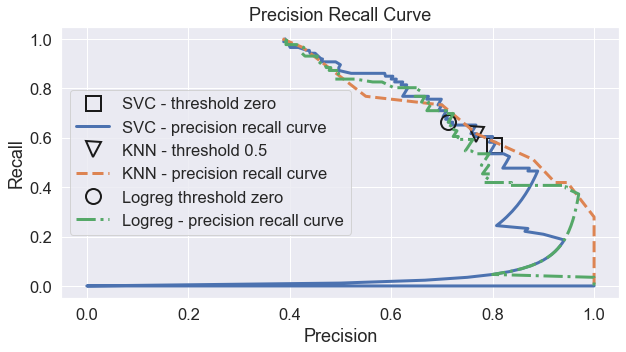

In [27]:
#altogether

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

#SVC
plt.plot(precision_svc[close_zero_svc], recall_svc[close_zero_svc], "s", markersize=15, label="SVC - threshold zero",fillstyle="none", c="k", mew=2)

plt.plot(precision_svc, recall_svc, label="SVC - precision recall curve", linestyle="solid", linewidth=3)


#KNN
plt.plot(precision_knn[close_zero_knn], recall_knn[close_zero_knn], "v", markersize=15, label="KNN - threshold 0.5",fillstyle="none", c="k", mew=2)

plt.plot(precision_knn, recall_knn, label="KNN - precision recall curve",linestyle="dashed", linewidth=3)

#logreg
plt.plot(precision_logreg[close_zero_logreg], recall_logreg[close_zero_logreg], "o", markersize=15, label="Logreg threshold zero",fillstyle="none", c="k", mew=2)

plt.plot(precision_logreg, recall_logreg, label="Logreg - precision recall curve", linestyle="dashdot", linewidth=3)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.legend(loc="best")

In [28]:
from sklearn.metrics import average_precision_score

#SVC
ap_svc = average_precision_score(y_test,svc.decision_function(X_test))
#KNN
ap_knn = average_precision_score(y_test, knn.predict_proba(X_test)[:,1])
#Logreg
ap_logreg = average_precision_score(y_test, logreg.decision_function(X_test))

In [29]:
print(
    "Average precision of svc:     {:.3f}".format(ap_svc)
)
print(
    "Average precision of knn:     {:.3f}".format(ap_knn)
)
print(
    "Average precision of logreg:  {:.3f}".format(ap_logreg)
)

Average precision of svc:     0.749
Average precision of knn:     0.772
Average precision of logreg:  0.766


## 9. ROC AUC curves
- False positive rate (FPR) vs. true positive rate (TPR)

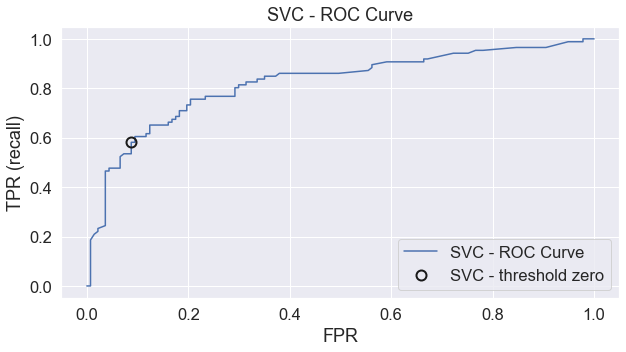

In [30]:
#SVC

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr_svc, tpr_svc, label="SVC - ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("SVC - ROC Curve")

close_zero_svc = np.argmin(np.abs(thresholds_svc))

plt.plot(fpr_svc[close_zero_svc],tpr_svc[close_zero_svc],"o", markersize=10,label="SVC - threshold zero", fillstyle="none", c="k", mew=2)
plt.legend(loc="best")

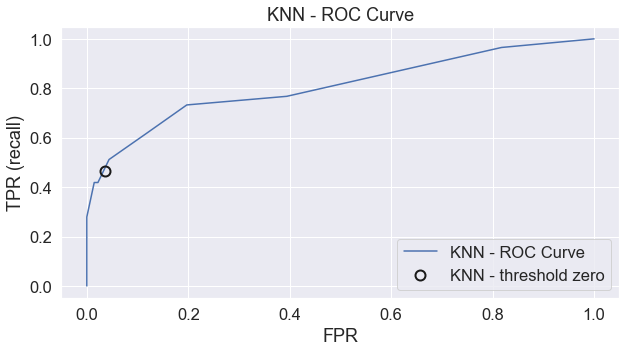

In [31]:
#KNN

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test,  knn.predict_proba(X_test)[:,1])

plt.plot(fpr_knn, tpr_knn, label="KNN - ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("KNN - ROC Curve")

close_zero_knn = np.argmin(np.abs(thresholds_knn))

plt.plot(fpr_svc[close_zero_knn],tpr_svc[close_zero_knn],"o", markersize=10,label="KNN - threshold zero", fillstyle="none", c="k", mew=2)
plt.legend(loc=4)

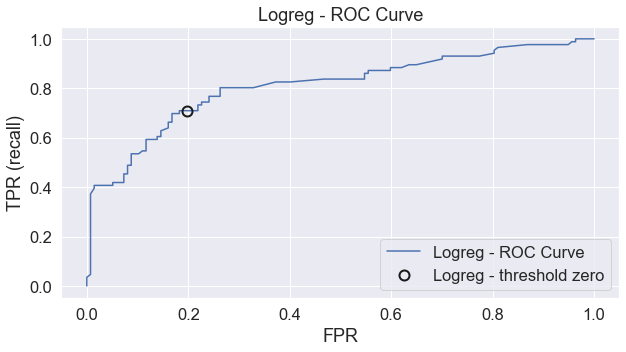

In [32]:
#logreg

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test,  logreg.decision_function(X_test))

plt.plot(fpr_logreg, tpr_logreg, label="Logreg - ROC Curve")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("Logreg - ROC Curve")

close_zero_logreg = np.argmin(np.abs(thresholds_logreg))

plt.plot(fpr_svc[close_zero_logreg],tpr_svc[close_zero_logreg],"o", markersize=10,label="Logreg - threshold zero", fillstyle="none", c="k", mew=2)
plt.legend(loc=4)

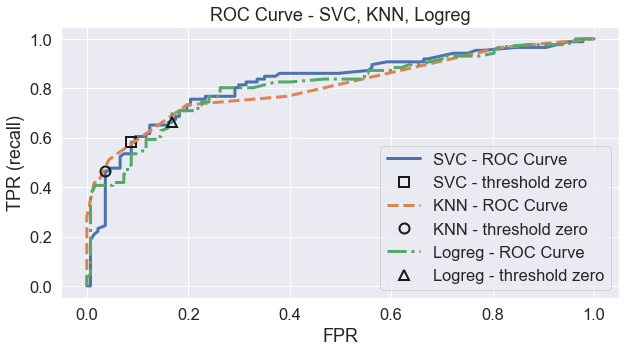

In [33]:
#altogether

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("ROC Curve - SVC, KNN, Logreg")


#SVC
plt.plot(fpr_svc, tpr_svc, label="SVC - ROC Curve", linestyle="solid", linewidth=3)

plt.plot(fpr_svc[close_zero_svc],tpr_svc[close_zero_svc],"s", markersize=10,label="SVC - threshold zero", fillstyle="none", c="k", mew=2)


#KNN
plt.plot(fpr_knn, tpr_knn, label="KNN - ROC Curve", linestyle="--", linewidth=3)

plt.plot(fpr_svc[close_zero_knn],tpr_svc[close_zero_knn],"o", markersize=10,label="KNN - threshold zero", fillstyle="none", c="k", mew=2)

#logreg
plt.plot(fpr_logreg, tpr_logreg, label="Logreg - ROC Curve", linestyle="dashdot", linewidth=3)

plt.plot(fpr_logreg[close_zero_logreg],tpr_logreg[close_zero_logreg],"^", markersize=10,label="Logreg - threshold zero", fillstyle="none", c="k", mew=2)

plt.legend(loc=4)

In [34]:
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
logreg_auc = roc_auc_score(y_test, logreg.decision_function(X_test))

In [35]:
print(
    "AUC for SVC:    {:.3f}".format(svc_auc)
)
print(
    "AUC for KNN:    {:.3f}".format(knn_auc)
)
print(
    "AUC for Logreg: {:.3f}".format(logreg_auc)
)

AUC for SVC:    0.820
AUC for KNN:    0.808
AUC for Logreg: 0.809


## For later, still trying to understand

In [36]:
grid = GridSearchCV(SVC(), param_grid=param_grid_svc, scoring="roc_auc")
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [37]:
print(
    "Best parameters: ", grid.best_params_ 
)
print(
    "Best cross-validation score (average precision):{:.3f}".format(grid.best_score_)
)

Best parameters:  {'C': 0.01, 'gamma': 1}
Best cross-validation score (average precision):0.855


In [38]:
res = cross_validate(SVC(), features_fit_trans,np.ravel(target),scoring=["accuracy","average_precision","roc_auc"], return_train_score=True, cv=5)

display(
    pd.DataFrame(res)
)

,fit_time,score_time,test_accuracy,train_accuracy,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc
0,0.014591,0.014154,0.748603,0.799157,0.802643,0.805204,0.808498,0.819545
1,0.014522,0.012098,0.803371,0.813464,0.763771,0.819142,0.823529,0.830117
2,0.016401,0.011944,0.792135,0.810659,0.777237,0.775680,0.796056,0.800746
3,0.013505,0.011847,0.769663,0.806452,0.741217,0.790919,0.758356,0.822016
4,0.013590,0.012542,0.820225,0.803647,0.814242,0.774075,0.819372,0.803946
